
     "The only function of economic forecasting is to make astrology look respectable." 


A real forecaster may not like this quotation because it expresses that forecasting is some sort of dubious mystical activity. In truth, most forecasts are the result of modern, replicable and largely quantitative methods. Among others, one key field of forecasting is economics. Economic agents such as  governments, businesses, central banks and financial institutions make forecasts of the major economic variables like gross domestic product (GDP), unemployment, consumption, inflation and interest rates.

The aim of this post is to estimate different models to forecast Swiss GDP growth after an appreciation of 15% of the CHF vis-à-vis the EUR as it was the case when the SNB repealed the minimum rate. The models predict considerably lower GDP growth which confirmed that the models reflect the negative relationship between GDP growth and the exchange rate. In fact an ARMAX- and a VARMAX model are elaborated. The results show that both types of models exhibit quite reasonable predictive power. 

This estimation is done with the SARIMAX and the VARMAX routines of [Statsmodels](www.statsmodels.org).
First of all we import some packages and load the data, which can be found on the database of the St. Louis Fred and the OECD. In fact the VARMAX model contains besides Swiss GDP growth also inflation, unemployment rate, exports growth, a shorter and a longer yield spread. The exogenous data contains lagged GDP of the Euro Area and lagged CHF/EUR exchangerate. Conducting Granger Causality tests shows that from a statistically point of view its justified to treat the exchange rate as exogenous which is an assumption that is often used when forecasting GDP growth in a small open economy, although it does not make a lot of sense economically.  Economically it can reasonably be assumed that Euro Area GDP growth is exogenous to Swiss GDP growth because Switzerland is a small open economy and thus is unlikely to affect GDP growth in the EU. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.io.data import DataReader
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

/Users/anaconda/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


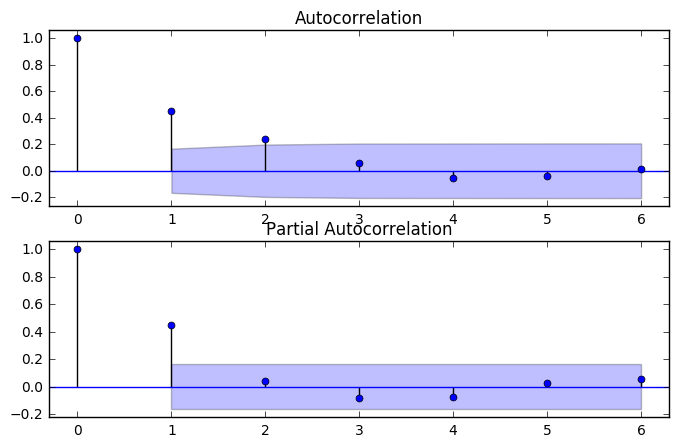

In [2]:
table = pd.read_excel('forecasting_data.xlsx')
idx = table.observation_date
data = table[['SwissGDP','Inflation','Unemployment','Exports','Shortspread','Longspread']]
data.index=idx
xdata = table[['EUR/CHF','EUR/CHF_L1','EUR/CHF_L2','EUR/CHF_L3','EuroGDP_L1']]
xdata.index=idx
SwissGDP = data[['SwissGDP']]

fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(SwissGDP, lags=6, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(SwissGDP, lags=6, ax=ax2)
plt.show(fig1)

The figure above shows the ACF and the PACF of Swiss GDP growth. The ACF is significantly different from zero up to two lags while the PACF is only significantly different from zero for lag one. Therefore, p = 4 and q = 4 should be according to Box and Jenkins (1976) an appropriate maximum order for the ARMAX(p,q) model. In an automated procedure several information criteria are calculated to trade-off explanatory power with parsimony.

In [3]:
aic = pd.DataFrame(np.zeros((5,5), dtype=float))
bic = pd.DataFrame(np.zeros((5,5), dtype=float))

# Iterate over all ARMA(p,q) models with p,q in [5,5]
for p in range(5):
    for q in range(5):
        if p == 0 and q == 0:
            continue
            
        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(SwissGDP, xdata, order=(p,0,q), enforce_invertibility=True)
        try:
            res = mod.fit(maxiter=5000, disp = False)
            aic.iloc[p,q] = res.aic
            bic.iloc[p,q] = res.bic
        except:
            aic.iloc[p,q] = np.nan
            bic.iloc[p,q] = np.nan
        
aic.iloc[0,0] = np.nan
bic.iloc[0,0] = np.nan

print(aic)
print(bic)

q = aic.min().idxmin()
p = aic.idxmin()[q]

            0           1           2           3           4
0         NaN  264.613956  265.895288  263.718360  265.311417
1  262.245898  255.756811  251.495686  255.245270  257.234556
2  262.613856         NaN         NaN  255.466728  256.541741
3  261.917222  263.947968         NaN         NaN         NaN
4  263.823613  265.827257         NaN         NaN         NaN
            0           1           2           3           4
0         NaN  285.155274  289.371079  290.128625  294.656156
1  282.787215  279.232602  277.905952  284.590009  289.513770
2  286.089647         NaN         NaN  287.745941  291.755428
3  288.327487  293.292707         NaN         NaN         NaN
4  293.168352  298.106470         NaN         NaN         NaN


As can be seen above, the AIC and the BIC are both minimized for $p = 1$ and $q = 2$, therefore an $ARMAX(1,2)$ model is used here. Before estimating the model, some notes about the general $ARMA$ model.


Due to Wold (1938), a covariance-stationary equation can be written as the so-called "Wold-Decomposition": 
$$\begin{equation*}
Y_t = \mu + \sum_{j=0}^{\infty} \psi_j  \epsilon_{t-j}
\end{equation*}$$
where $\epsilon_t$ is the error from forecasting $Y_t$ solely with lagged values of $Y_t$. A Wold representation in principle requires fitting an infinite number of parameters ($\psi_1, \psi_2, ...$). With a finite number of observations this will never be possible.  However, in practice a typical assumption is that $Y_t$ is a causal process and $\psi(L)$ can be approximated from its causal representation:
$$\begin{equation*}
\sum_{j=0}^\infty \psi_j L^j = \frac{\Theta(L)}{\Phi(L)} \equiv  \frac{(1 + \theta_1L + \theta_2L^2 + ... + \theta_qL^q)}{(1 - \phi_1L - \phi_2L^2 - ... - \phi_pL^p)}
\end{equation*}$$

ARMA modelling seeks a finite parameter approximation to the Wold representation. Box and Jenkins (1976) emphasise parsimony in the choice of the AR order $p$ and the MA $q$ order

The general ARMA model is:
$$\begin{equation*}
Y_t = \sum_{i=0}^p \phi_i Y_{t-i} + \epsilon_t + \sum_{j=0}^q \theta_j \epsilon_{t-j} \end{equation*}$$
where $\epsilon_t$ is a disturbance term(white noise) and $Y_t$ is the stationary forecast variable. The typical strategy implies: 


* Select an appropriate maximum $p, q$ order for the $ARMA (p, q)$ model.
* Estimate $\phi(L)$ and $\theta(L)$ associated with each choice of $p$ and $q$.
* Select the best model (choice of $p$ and $q$) based on model diagnostics.



                           Statespace Model Results                           
Dep. Variable:               SwissGDP   No. Observations:                  139
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -116.748
Date:                Mon, 09 Jan 2017   AIC                            251.496
Time:                        22:28:46   BIC                            277.906
Sample:                    04-01-1980   HQIC                           262.228
                         - 10-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EUR/CHF        0.0316      0.021      1.535      0.125      -0.009       0.072
EUR/CHF_L1     0.0415      0.026      1.609      0.108      -0.009       0.092
EUR/CHF_L2     0.0575      0.026      2.194      0.0

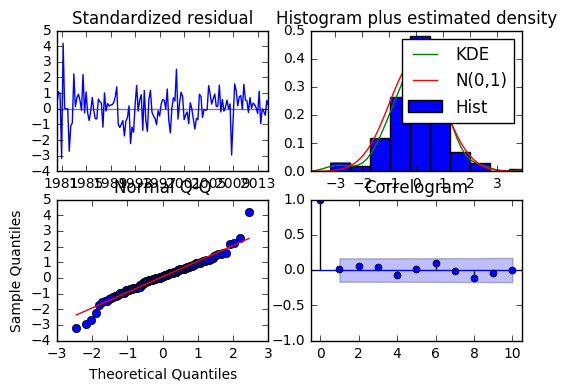

In [4]:
# Statespace
mod = sm.tsa.statespace.SARIMAX(SwissGDP, xdata, order=(p,0,q))
res = mod.fit(maxiter=5000)
fig2 = res.plot_diagnostics()
print(res.summary())
plt.show(fig2)

The residual plot suggest that the ARMA model fits pretty well. The fitted values track the actual values and even cover the recession during the financial crisis. The residuals look reasonably independent and identically distributed (i.i.d.) according to the ACF and also resemble a normal distribution. By looking at the ACF of the residuals it’s observable that there are no lags which are autocorrelated.

Next, we generate the exogenous variables for the forecasting task. For simplicity, it is assumed that the exchange rate decreases by 15% in 2015Q1 (due to the decision of the SNB to repeal the euro minimum rate on January 15) and is zero otherwise. The lagged Euro Area GDP is set to its mean. Then the model is used to forecast 12 quaters ahead.

In [5]:
# Generate Exogenous Data for Forecasting
fx = pd.DataFrame(index=list(range(0, 12)) , columns=xdata.columns)
fx = fx.fillna(0)
fx.iloc[0,0] = -15.00
fx.iloc[1,1] = -15.00
fx.iloc[2,2] = -15.00
fx.iloc[3,3] = -15.00

fx.iloc[0:12,4] = np.mean(xdata[['EuroGDP_L1']]).values

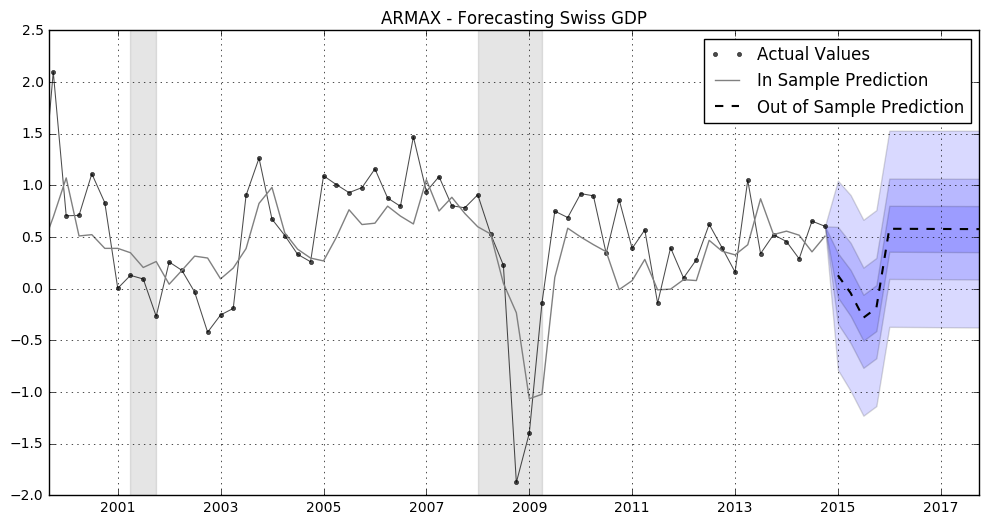

In [6]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 11
predict = res.get_prediction(end=mod.nobs + nforecast, exog = fx)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci90 = predict.conf_int(alpha=0.1)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)
fidx = predict_ci90.index
predict_ci90.iloc[138,:] = SwissGDP.iloc[138,:].values
predict_ci60.iloc[138,:] = SwissGDP.iloc[138,:].values
predict_ci30.iloc[138,:] = SwissGDP.iloc[138,:].values

# Graph
fig3, ax = plt.subplots(figsize=(12,6))
ax.grid()
ax.plot(idx,SwissGDP,'k',label='', alpha=0.7, linewidth=0.75)
ax.plot(idx,SwissGDP,'k.', label='Actual Values', alpha=0.7, linewidth=0.75)

# Plot
ax.plot( predict.predicted_mean[:-nforecast-1], 'gray',label='In Sample Prediction')
ax.plot(fidx[-nforecast-1:], predict.predicted_mean[-nforecast-1:], 'k--', linestyle='--', linewidth=1.5,label='Out of Sample Prediction')
ax.fill_between(fidx[-nforecast-2:], predict_ci90.iloc[-nforecast-2:, 0], predict_ci90.iloc[-nforecast-2:, 1], alpha=0.15, label= '')
ax.fill_between(fidx[-nforecast-2:], predict_ci60.iloc[-nforecast-2:, 0], predict_ci60.iloc[-nforecast-2:, 1], alpha=0.15, label= '')
ax.fill_between(fidx[-nforecast-2:], predict_ci30.iloc[-nforecast-2:, 0], predict_ci30.iloc[-nforecast-2:, 1], alpha=0.15, label= '')

# Retrieve and also plot the NBER recession indicators
rec = DataReader('USREC', 'fred', start=idx[0], end=idx[138])
recr = rec.iloc[0:413:3,0]
ylim = ax.get_ylim()
ax.fill_between(recr.index, ylim[0], ylim[1], recr, facecolor='k', alpha=0.1);

ax.legend()
ax.set_xlim(730000.0, 736603.0)
ax.set(title='ARMAX - Forecasting Swiss GDP');
plt.show(fig3)

We see this scenario predicts Swiss GDP to be considerably lower because of the appreciation. This reflects the positive relationship between a depreciation and GDP growth. Therefore, an appreciation of the swiss franc vis-à-vis the euro leads to lower Swiss GDP growth.

Next, we do the same, including some other variables. That is inflation, unemployment rate, exports growth, a shorter and a longer yield spread. As the automated procedure suggests to take a $VARMAX(2,0)$ model, some notes about VAR models: 


A $VAR(p)$ process in it's basic form is: 
$$\begin{equation*}
y_t = c + \Phi_1y_{t-1} + ... + \Phi_py_{t-p}  + \epsilon_t
\end{equation*}$$
Here $y_t$ represents a set of variables collected in a vector, c denotes a vector of constants, $\Phi_j$ a matrix of autoregressive coefficients and $\epsilon_t$ is white noise. Since the parameters of $\Phi_j$ are unknown, we have to estimate these parameters. To do so, the following is defined: 
$$\begin{align}
Y &:= (y_1, y_2, ... , y_T) \notag \\ \notag
B &:= (c, \Phi_1, \Phi_2, ... , \Phi_p) \\ \notag
Z &:= \left[ \begin{array}{cccc}
1 & 1 & ... & 1\\
y_{0} & y_1 & ... & y_{T-1} \\ 
\vdots & \vdots & \ddots & \vdots\\ 
y_{-p+1} & y_{-p+2} & ... & y_{T-p}
\end{array}
\right] \\ \notag
U &:= (\epsilon_1, \epsilon_2, ... , \epsilon_T) \\ \notag
\end{align}$$ 
The VAR(p) can now be written compactly as
$$\begin{equation*}
Y = BZ + U
\end{equation*}$$

Coefficients can now easily be estimated via OLS or Maximum Likelihood.

In [7]:
# Iterate over all VARMAX(p,q) models with p,q in [5,5]
for p in  range(5):
    for q in  range(5):
        if p == 0 and q == 0:
            continue
            
        # Estimate the model with no missing datapoints
        mod = sm.tsa.VARMAX(data, xdata, order=(p,q), enforce_invertibility=True)
        try:
            res = mod.fit(maxiter=100, disp = False)
            aic.iloc[p,q] = res.aic
            bic.iloc[p,q] = res.bic
        except:
            aic.iloc[p,q] = np.nan
            bic.iloc[p,q] = np.nan
        
aic.iloc[0,0] = np.nan
bic.iloc[0,0] = np.nan

print(aic)
print(bic)

q = aic.min().idxmin()
p = aic.idxmin()[q]

             0            1            2            3            4
0          NaN  2327.172822  2268.377277  2268.557987  2184.283078
1  1738.137507  1671.993551  1703.809500  1755.831867  1725.441905
2  1595.173709  1697.197868  1720.744466  1837.434508  1814.274102
3  1691.637533  1675.031941  1755.366443  1863.706566  1953.631488
4  1709.367598  1702.215088  1805.406073  1898.357519  1983.406628
             0            1            2            3            4
0          NaN  2600.078897  2646.924414  2752.746186  2774.112339
1  2011.043582  2050.540689  2187.997699  2345.661128  2420.912227
2  1973.720847  2181.386067  2310.573727  2532.904830  2615.385485
3  2175.825732  2264.861201  2450.836765  2664.817950  2860.383933
4  2299.196858  2397.685410  2606.517457  2805.109964  2995.800135


As already mentioned above, both information criteria are minimized within the $VARMAX(2,0)$ model.

                                                           Statespace Model Results                                                          
Dep. Variable:     ['SwissGDP', 'Inflation', 'Unemployment', 'Exports', 'Shortspread', 'Longspread']   No. Observations:                  139
Model:                                                                                       VARX(2)   Log Likelihood                -666.505
                                                                                         + intercept   AIC                           1591.009
Date:                                                                               Mon, 09 Jan 2017   BIC                           1969.556
Time:                                                                                       23:28:12   HQIC                          1744.841
Sample:                                                                                   04-01-1980                                         
      

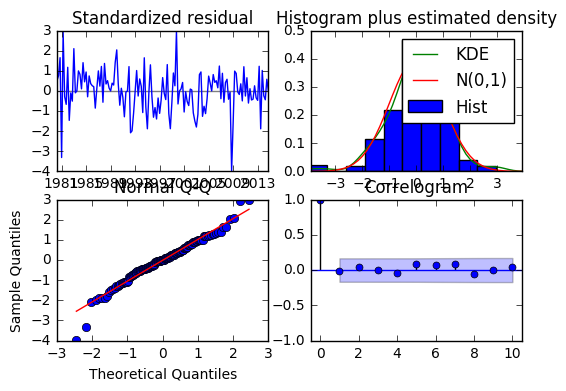

In [8]:
# Statespace
mod = sm.tsa.VARMAX(data, xdata, order=(p,q), enforce_invertibility=True)
res = mod.fit(maxiter=5000, disp = False)
fig4 = res.plot_diagnostics(0)
print(res.summary())
plt.show(fig4)

The residual diagnostics plot looks quite similar to the one of the ARMAX model, therefore we conclude same things as above.

As the ARMAX model, the VARMAX model predicts the GDP to be considerably lower.

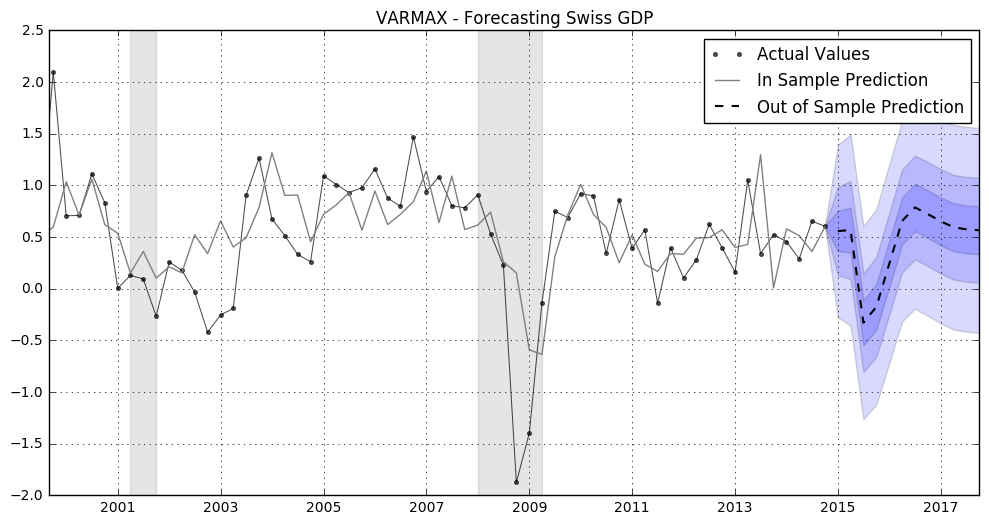

In [9]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 11
predict = res.get_prediction(end=mod.nobs + nforecast, exog = fx)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci90 = predict.conf_int(alpha=0.1)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)
fidx = predict_ci90.index
predict_ci90.iloc[138,:] = SwissGDP.iloc[138,:].values
predict_ci60.iloc[138,:] = SwissGDP.iloc[138,:].values
predict_ci30.iloc[138,:] = SwissGDP.iloc[138,:].values

# Graph
fig5, ax = plt.subplots(figsize=(12,6))
ax.grid()
ax.plot(idx,SwissGDP,'k',label='', alpha=0.7, linewidth=0.75)
ax.plot(idx,SwissGDP,'k.', label='Actual Values', alpha=0.7, linewidth=0.75)

# Plot
ax.plot( predict.predicted_mean[:-nforecast-1][['SwissGDP']], 'gray',label='In Sample Prediction')
ax.plot(fidx[-nforecast-1:], predict.predicted_mean[-nforecast-1:][['SwissGDP']], 'k--', linestyle='--', linewidth=1.5,label='Out of Sample Prediction')
ax.fill_between(fidx[-nforecast-2:], predict_ci90.iloc[-nforecast-2:, 0], predict_ci90.iloc[-nforecast-2:, 6], alpha=0.15, label= '')
ax.fill_between(fidx[-nforecast-2:], predict_ci60.iloc[-nforecast-2:, 0], predict_ci60.iloc[-nforecast-2:, 6], alpha=0.15, label= '')
ax.fill_between(fidx[-nforecast-2:], predict_ci30.iloc[-nforecast-2:, 0], predict_ci30.iloc[-nforecast-2:, 6], alpha=0.15, label= '')

# Retrieve and also plot the NBER recession indicators
rec = DataReader('USREC', 'fred', start=idx[0], end=idx[138])
recr = rec.iloc[0:413:3,0]
ylim = ax.get_ylim()
ax.fill_between(recr.index, ylim[0], ylim[1], recr, facecolor='k', alpha=0.1);

ax.legend()
ax.set_xlim(730000.0, 736603.0)
ax.set(title='VARMAX - Forecasting Swiss GDP');
plt.show(fig5)